# TP2 : démultiplexage stéréophonique

Aujourd'hui, l'ensemble des données sonores rendues disponibles par la radio ou par la télévision est de nature stéréophonique. Néanmoins, historiquement, cela n'a pas toujours été le cas. A l'origine, les transmissions étaient en effet *monophoniques*, simplement restituées à partir d'un seul haut-parleur. Ainsi, lors du passage à
la stéréo, il a fallu veiller à ce que l'information audio stéréophonique soit représentée de sorte que les anciens équipements monophoniques restent compatibles. De plus, de nombreux postes radio basiques (radio-réveils, etc.) sont aujourd'hui toujours en vente, et diffusent un son uniquement monophonique.

Concrètement, la création, la transmission et la réception d'un signal stéréophonique s'opèrent de la façon suivante :
<img src="img/transmission.png" width=600>

- Tout d'abord, *un seul et unique signal* $x_{\text{stéréo}}[n]$, contenant l'information stéréophonique gauche et droite, est obtenu à partir d'un *multiplexeur stéréophonique* ;
- Ensuite, cet unique signal est transmis (par exemple, à l'aide  d'une modulation de fréquence) ;
- Puis, l'appareil de réception doit démoduler le signal reçu afin d'obtenir le signal $\hat{x}_{\text{stéréo}}[n]$, signal stéréophonique reçu qu'on espère quasi-identique au signal $x_{\text{stéréo}}[n]$ émis.
- Enfin, sur la base du signal stéréphonique reçu, un *démultiplexeur stéréo* permet de restituer indépendemment les signaux gauche et droit initiaux.

**C'est cette dernière opération que nous allons étudier ici**

La contrainte principale pour une telle transmission, comme mentionné auparavant, est que le signal doit tout de même pouvoir être reçu par des récepteurs non équipés pour la stéréophonie.  Cette compatibilité avec les postes monophoniques est obtenue en combinant les signaux des voies droite (D) et gauche (G) et en leur attribuant une occupation spectrale bien identifiée (et normalisée). Ainsi, l'allure du contenu fréquentiel (TFSD) du signal stéréophonique $x_{\text{stéréo}}[n]$ est représenté sur la figure suivante (tracé limité entre 0 et 53kHz) :
<img src="img/spectre.png" width=600>
<p style="text-align: center;">Fig.1 : Spectre du signal stéréophonique</p>

## Objectif
*L'objectif de ce TP est de proposer une solution, à base de filtrage numérique, permettant d'extraire du signal $x_{\text{stéréo}}[n]$ les deux signaux d'origine G et D. Idéalement, ces deux signaux doivent être parfaitement séparés, de façon à garantir une reproduction stéréophonique de qualité. Nous verrons que cela n'est possible que
sous certaines conditions que nous allons mettre en évidence dans la suite.*


In [1]:
%matplotlib notebook
import numpy as np
from IPython.display import display, Audio
import pylab as plt
from scipy.io.matlab import mio
from filtres import filtre
from demultiplex import demultiplex
%load_ext autoreload
%autoreload 2

In [9]:
import matplotlib
from matplotlib import pyplot as plt

#%matplotlib inline # Afficher les plots sur le notebook 

# 1/ Analyse du signal stéréophonique

Nous allons dans un premier temps analyser le signal stéréophonique fourni, et vérifier qu'il possède les caractéristiques attendues.

#### 1.1) On suppose que le signal stéréophonique est échantillonné à une fréquence $f_e = 132300$ Hz. Justifier le choix de cette fréquence d'échantillonnage.

#### 1.2) Charger le signal stéréophonique et tracer son allure temporelle. Commenter le résultat obtenu.

In [3]:
x = mio.loadmat('stereo.mat')
stereo = np.array(x['stereo'])[0]
Fe = 132300

<IPython.core.display.Javascript object>


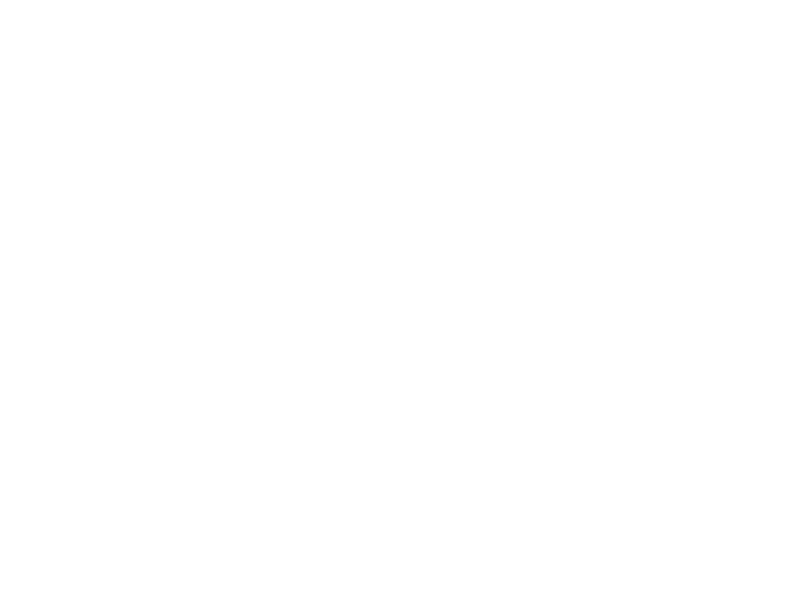

<IPython.core.display.Javascript object>


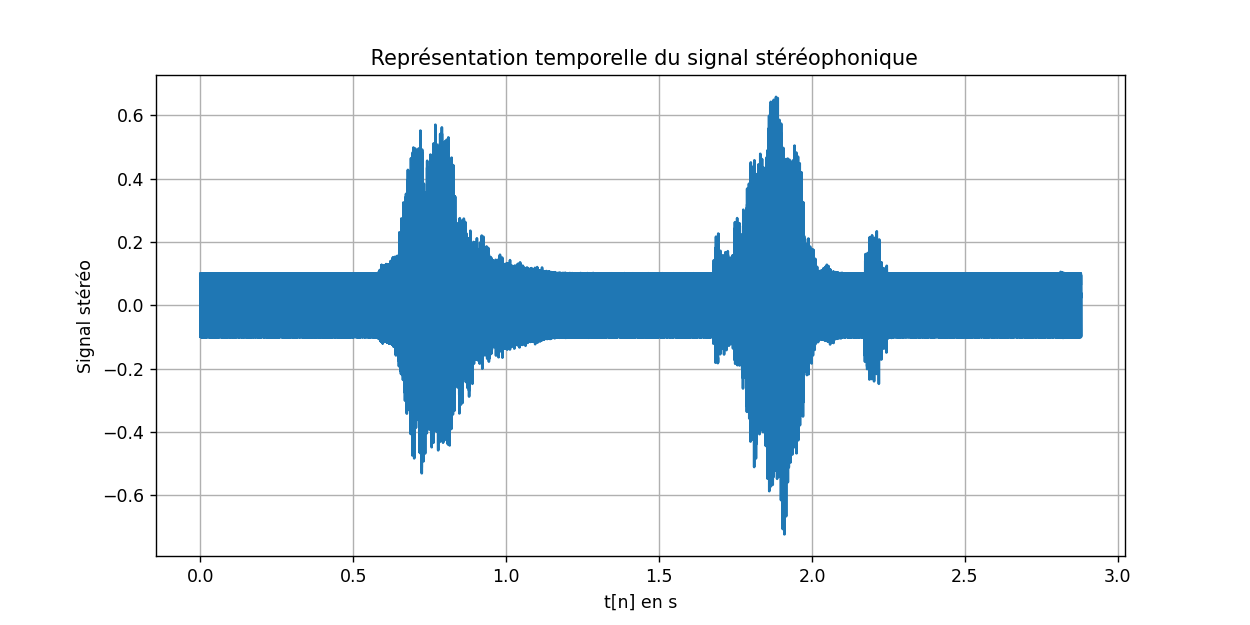

In [8]:
# Code à compléter
# Le signal est déja echantilloné et contient donc N points 

N = len(stereo)# Nombre de points 
Te = 1/Fe
t = np.arange(0, N*Te, Te) # Vecteur temporel composé de N*Te points espacés de Te etant donné que le signal est deja echantilloné
# t a donc la meme dimension que N 
plt.figure(facecolor='white')
plt.figure(figsize=(10,5))
plt.plot(t,stereo)
plt.xlabel('t[n] en s')
plt.ylabel('Signal stéréo')
plt.title(u'\n Représentation temporelle du signal stéréophonique')
plt.grid()
plt.show() 

#### 1.3) Analyser en fréquence le signal stéréophonique. Montrer que l'on retrouve un contenu fréquentiel proche de celui attendu. Préciser alors la bande passante du signal.

<IPython.core.display.Javascript object>


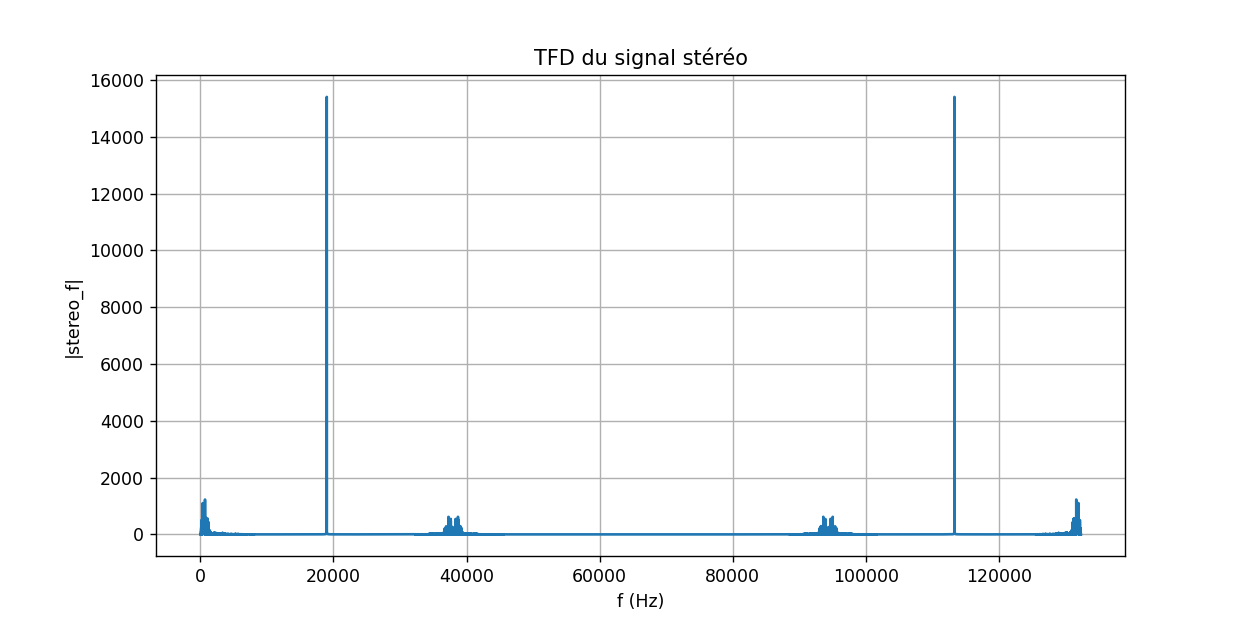

In [22]:
# Code à compléter
f = np.arange(0,Fe,Fe/N)
stereo_f = np.fft.fft(stereo)
plt.figure(figsize=(10,5))
plt.plot(f,abs(stereo_f))
plt.title('TFD du signal stéréo'); plt.xlabel('f (Hz)'); plt.ylabel('|stereo_f|'); plt.grid()
plt.show()

In [24]:
print("La frequence Fe/2 vaut : " , Fe/2," KHz")

La frequence Fe/2 vaut :  66150.0  KHz


# 2/ Démultiplexage stéréophonique

Maintenant que nous avons étudié les caractéristiques du signal stéréphonique, nous allons maintenant chercher à en extraire les deux signaux gauche (G) et droite (D). Pour cela, l'architecture suivante est utilisée :
<img src="img/archi.png" width=600>
<p style="text-align: center;">Fig.2 : Schéma de principe du démultiplexeur stéréo.</p>

Sur ce schéma sont indiqués en bleu les différents traitement que vous avez à réaliser. En particulier :
- le signal G+D (i.e. le signal monophonique) est extrait du signal stéréophonique par un filtre **FILTRE1** que vous aurez à spécifier et réaliser **dans la partie 2.1** ;
- la porteuse à 19kHz est extraite du signal stéréophonique par un filtre **FILTRE2** étudié **dans la partie 2.2** ;
- la sortie de **FILTRE2** est alors exploitée avec d'autres filtres et traitements élémentaires pour retrouver le signal G-D
- enfin, disposant des 2 signaux G+D et G-D, vous pourrez combiner ces signaux afin d'obtnir les signaux séparés G et D **dans la partie 2.3**.

## 2.1/ Extraction du signal monophonique

Une première étape du traitement visant à extraire les signaux G et D seuls consiste à extraire tout d'abord le signal G+D. Celui-ci correspond au signal monophonique qui sera émis par tous les postes non compatibles avec la stéréo. Cette opération est effectuée par un filtre numérique **FILTRE1** appliqué au signal stéréo $x_{stereo}(t)$.

#### 2.1.1) Sur quelle bande de fréquence se situe le signal G+D ? En déduire la nature (passe-haut, passe-bas, passe-bande) du filtre permettant d'extraire G+D du signal stéréo.

#### 2.1.2) Proposer alors le gabarit du filtre à synthétiser.

#### 2.1.3) Synthétiser un filtre RIF et RII satisfaisant le gabarit précent à l'aide de l'outils filtre() fourni.

<IPython.core.display.Javascript object>


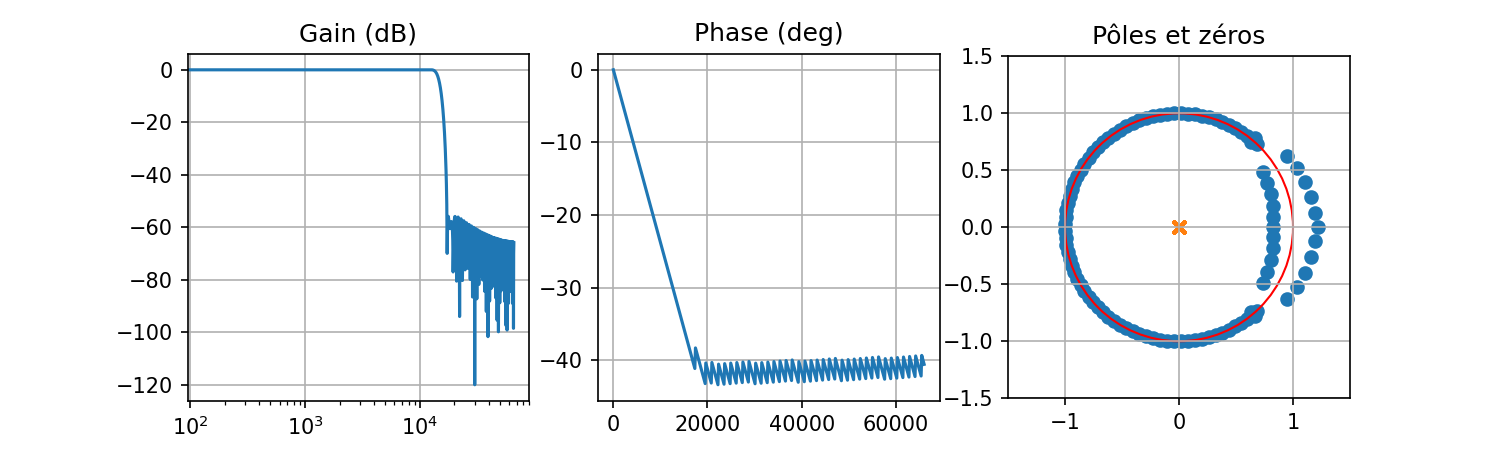

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [16]:
# Filtre RIF
FILTRE1_RIF = filtre()
fig, ax = plt.subplots(1,3,figsize=(10,3))
FILTRE1_RIF.display(ax, fig)

<IPython.core.display.Javascript object>


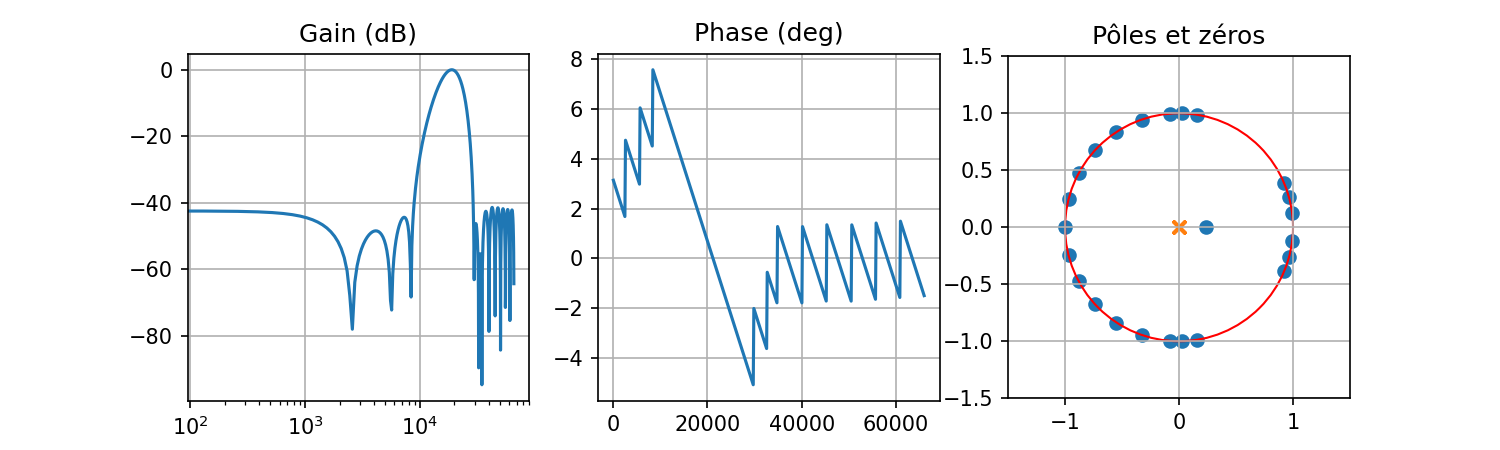

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fréquence de coupure mal saisie.


No handles with labels found to put in legend.


Fréquence de coupure mal saisie.


No handles with labels found to put in legend.


In [13]:
# Filtre RII
FILTRE1_RII = filtre()
fig, ax = plt.subplots(1,3,figsize=(10,3))
FILTRE1_RII.display(ax, fig)

#### 2.1.4) Comparer les réponses en fréquence (en gain et phase !) des deux filtres obtenus. En quoi ces réponses sont-elles différentes ? Quel est, selon vous, le "meilleur" filtre ?

#### 2.1.5) Visualiser les réponses impulsionnelles des deux filtres RIF et RII obtenus. Commenter et comparer leur allure.

<IPython.core.display.Javascript object>


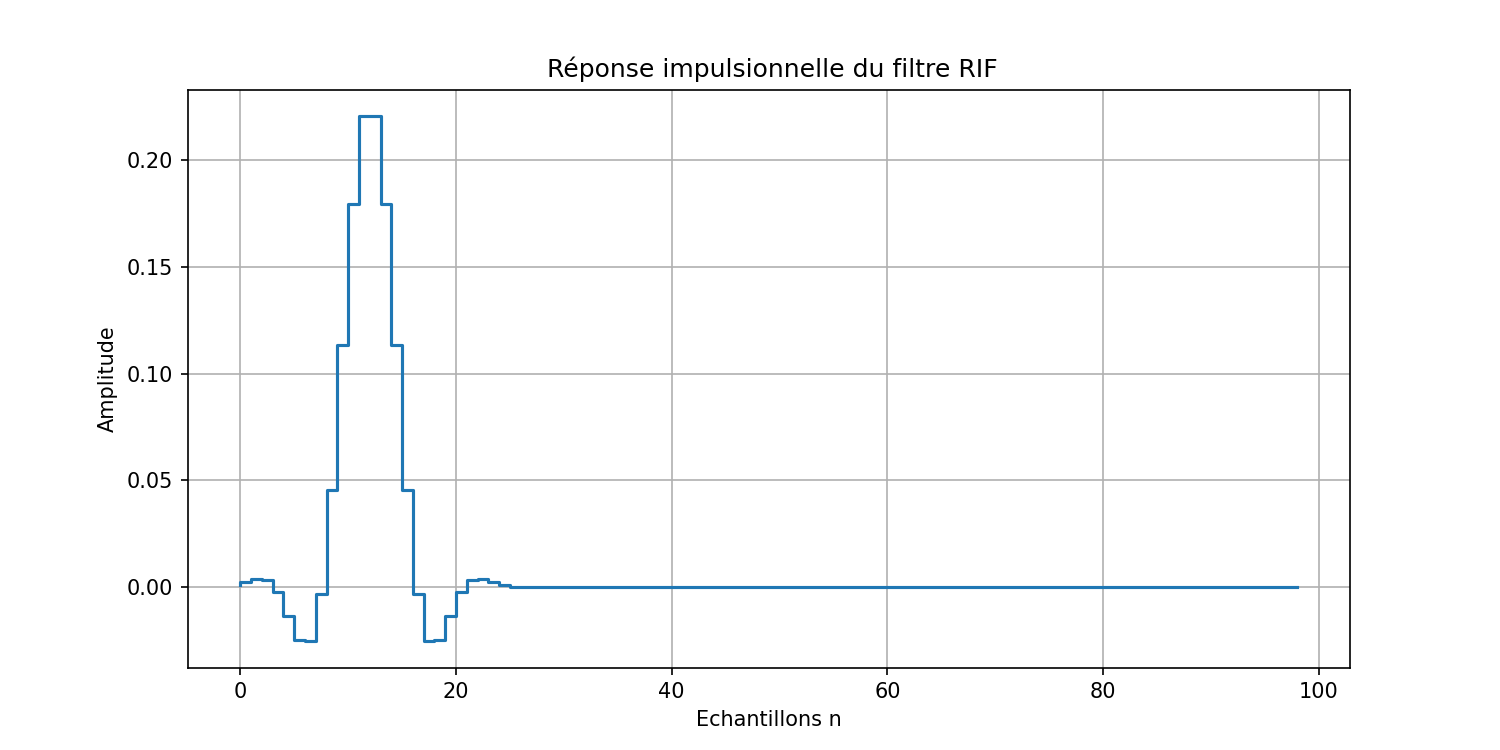

<IPython.core.display.Javascript object>


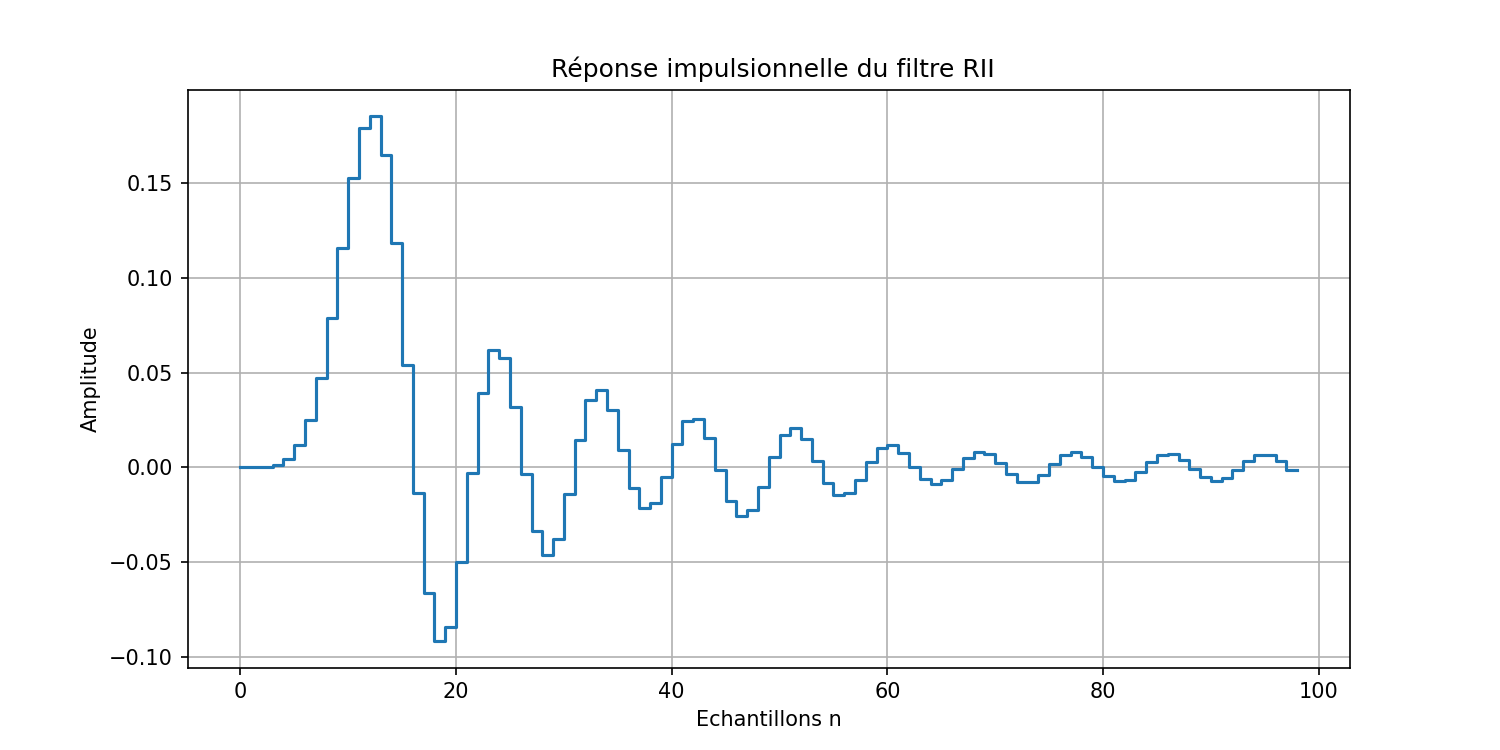

In [24]:
# Code à compléter

# Filtre RIF
n1, rep_imp1 = FILTRE1_RIF.impulse_response()
plt.figure(figsize=(10,5))
plt.step(n1, rep_imp1)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'\n Réponse impulsionnelle du filtre RIF')
plt.grid()

# Filtre RII
n2, rep_imp2 = FILTRE1_RII.impulse_response()
plt.figure(figsize=(10,5))
plt.step(n2, rep_imp2)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'\n Réponse impulsionnelle du filtre RII')
plt.grid()

#### 2.1.6) Utiliser les filtres synthétisés pour filtrer le signal stéréophonique $x_{stereo}[n]$ et récupérer ainsi le signal monophonique $x_{mono}[n]$.

<IPython.core.display.Javascript object>


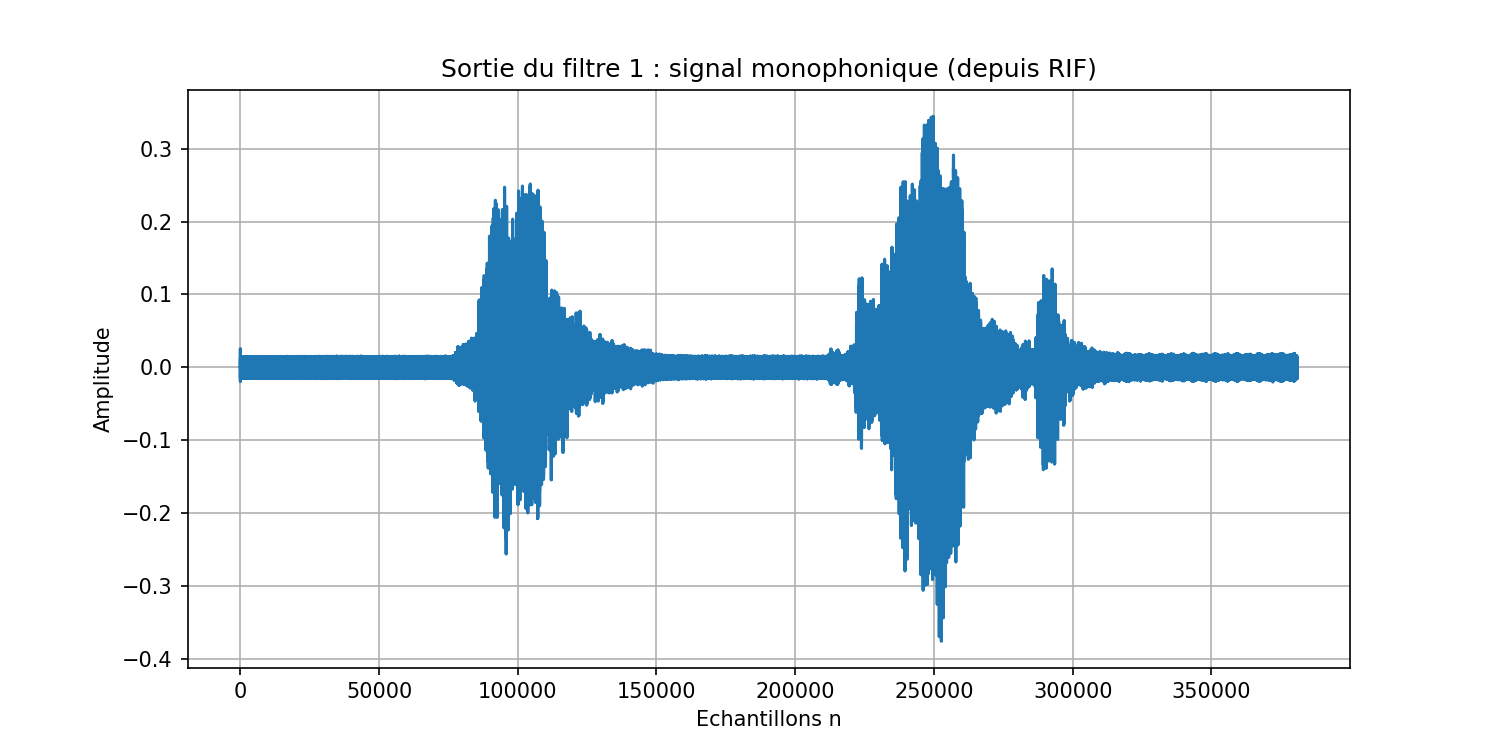

<IPython.core.display.Javascript object>


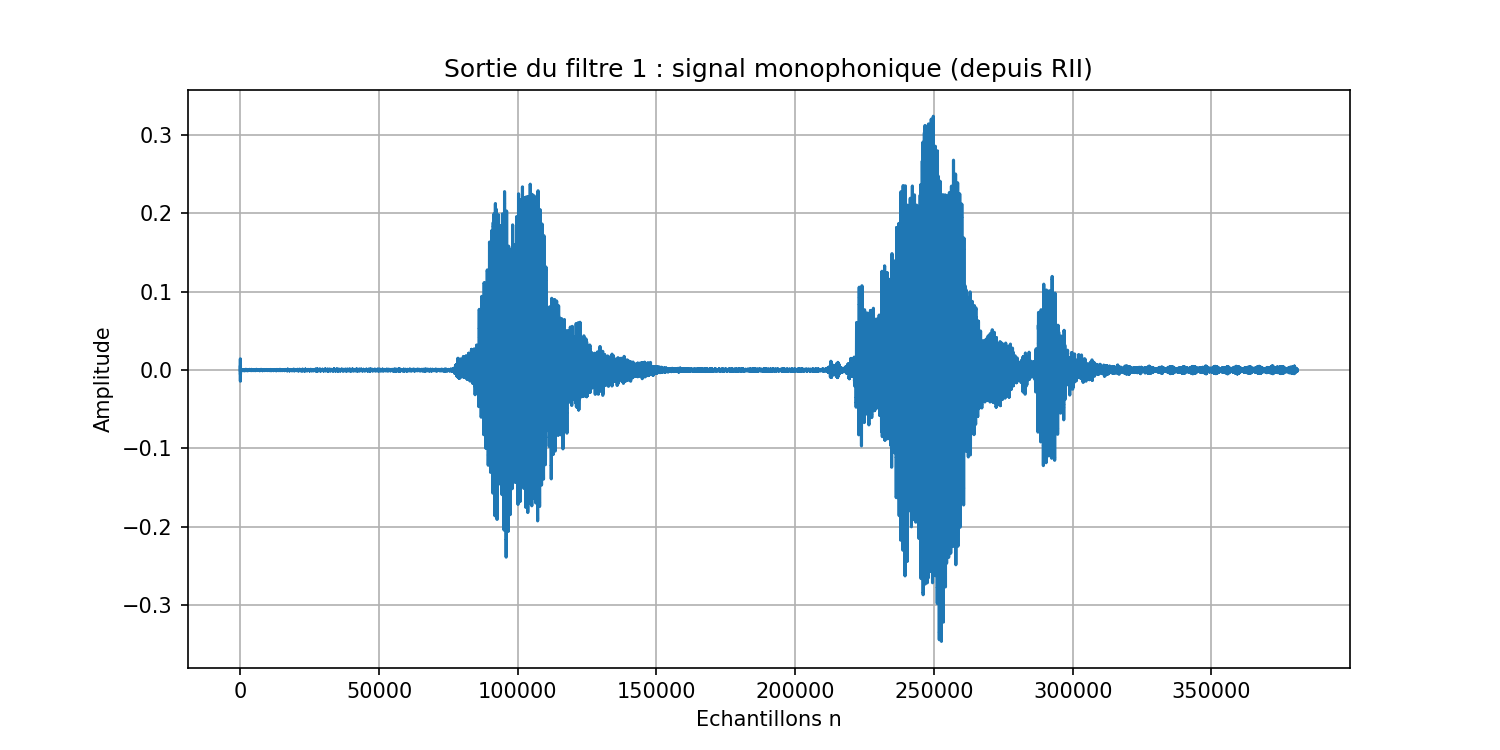

In [25]:
# Code à compléter : 

# Filtre RIF
n_rif, x_mono_rif = FILTRE1_RIF.filter(stereo)
plt.figure(figsize=(10,5))
plt.step(n_rif, x_mono_rif)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Sortie du filtre 1 : signal monophonique (depuis RIF)')
plt.grid()

# Filtre RII
n_rii, x_mono_rii = FILTRE1_RII.filter(stereo)
plt.figure(figsize=(10,5))
plt.step(n_rii, x_mono_rii)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Sortie du filtre 1 : signal monophonique (depuis RII)')
plt.grid()

#### 2.1.7) Déterminer et afficher le spectre du signal monophonique. Vérifier que le filtre précédent a bien supprimé les composantes fréquentielles souhaitées.

<IPython.core.display.Javascript object>


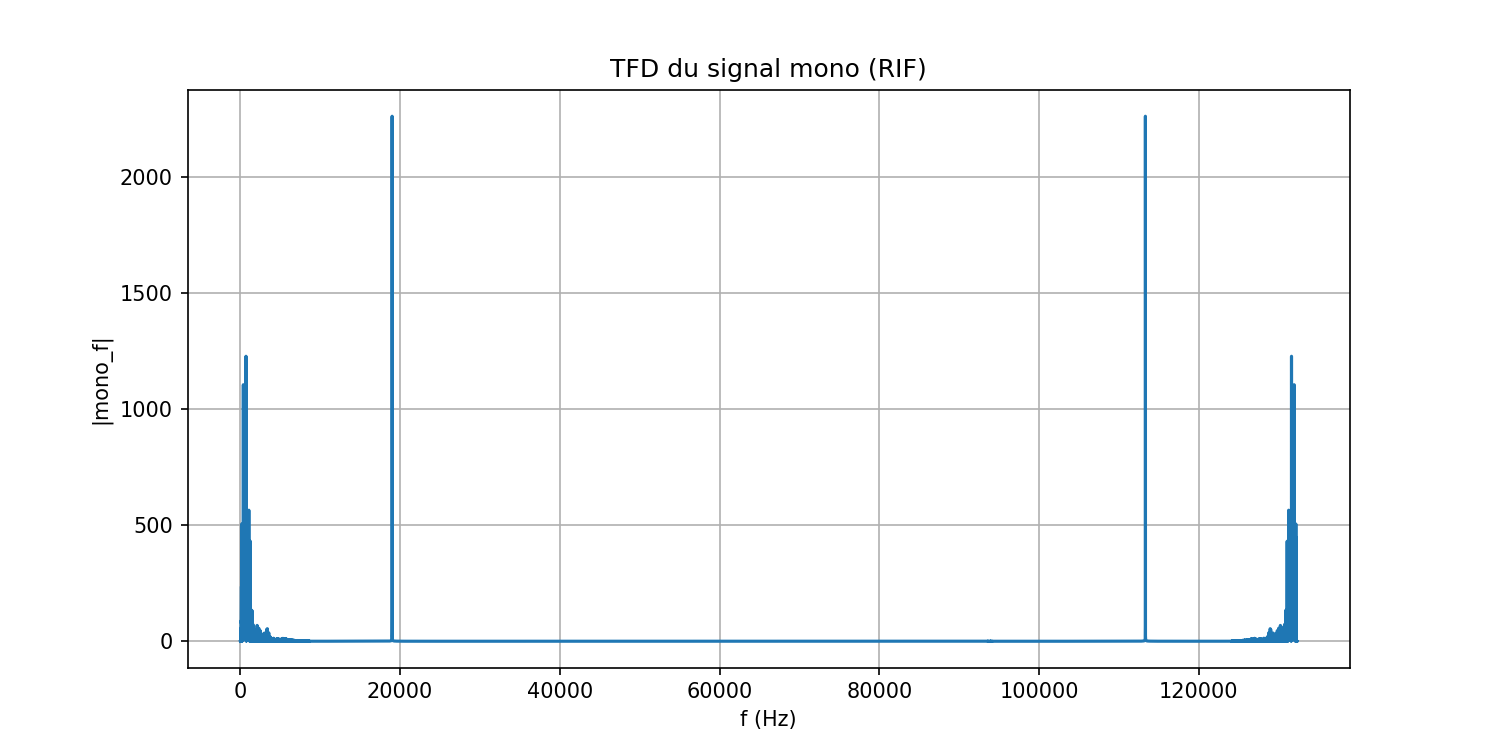

<IPython.core.display.Javascript object>


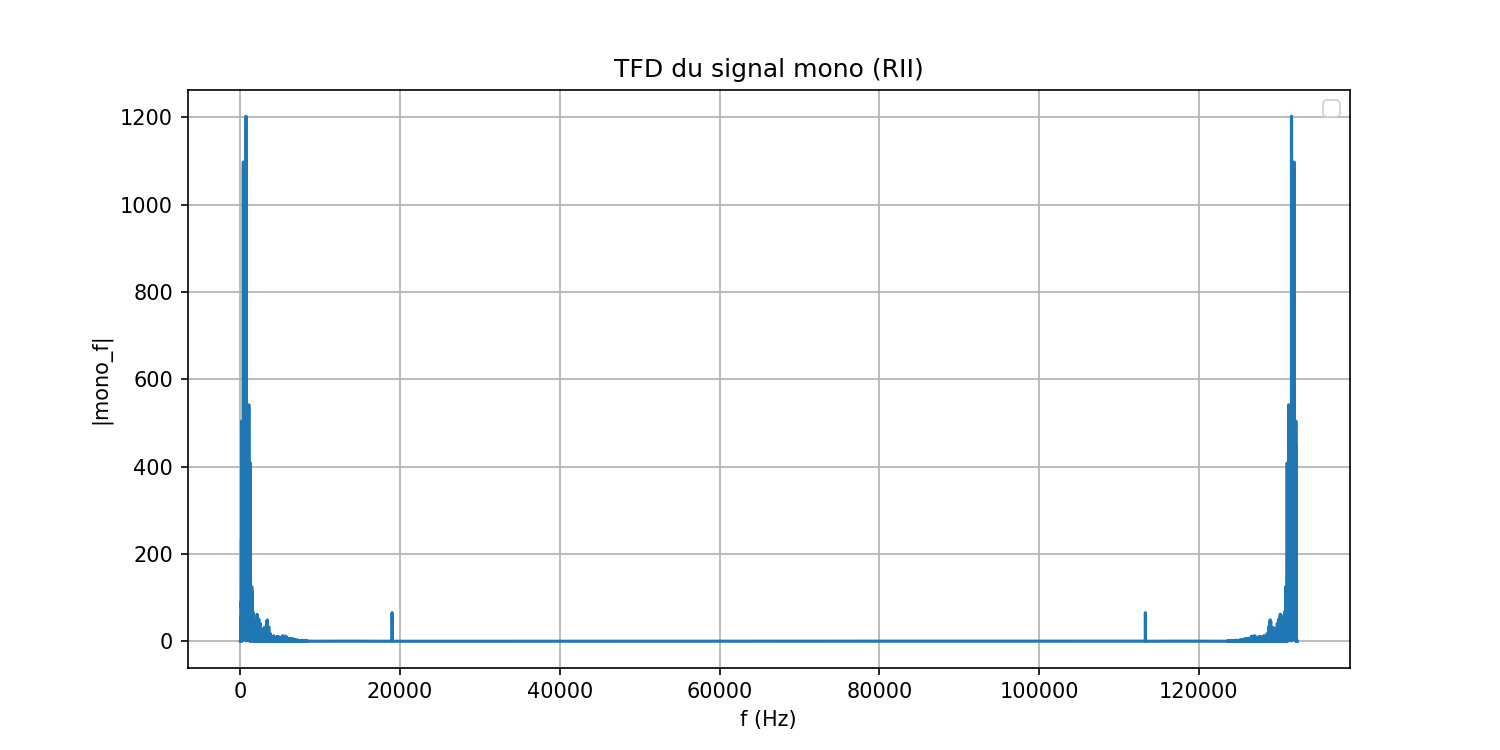

In [26]:
N = len(x_mono_rif)
f = np.arange(0,Fe,Fe/N)
mono_f_rif = np.fft.fft(x_mono_rif)
mono_f_rii = np.fft.fft(x_mono_rii)
plt.figure(figsize=(10,5))
plt.plot(f,abs(mono_f_rif))
plt.title('TFD du signal mono (RIF)'); plt.xlabel('f (Hz)'); plt.ylabel('|mono_f|'); plt.grid()
plt.figure(figsize=(10,5))
plt.plot(f,abs(mono_f_rii))
plt.title('TFD du signal mono (RII)'); plt.xlabel('f (Hz)'); plt.ylabel('|mono_f|'); plt.grid()

#### 2.1.8) Ecouter le signal monophonique et conclure.

In [27]:
# Code à compléter
display(Audio(x_mono_rif, rate=Fe))

## 2.2/ Extraction de la porteuse

Nous venons de déterminer un filtre FILTRE1 permettant d'extraire du signal stéréophonique l'information monophonique G+D. Pour rappel, nous travaillons sur l'architecture suivante :
<img src="img/archi.png" width=600>
<p style="text-align: center">Fig.3 : Schéma de principe du démultiplexeur stéréo.</p>
    
Il s'agit maintenant de déterminer le filtre numérique **FILTRE2** permettant d'extraire la porteuse à 19kHz située au sein du signal stéréophonique. Cette porteuse va permettre, grâce à l'utilisation d'autres filtre snumériques (en gris sur le schéma ci-dessus), d'extraire *in fine* le signal G-D.

#### 2.2.1) Compte tenu du spectre du signal stéréophonique représenté Fig.2, préciser la nature (passe-haut, passe-bas, passe-bande) du filtre **FILTRE2** permettant d'extraire la porteuse du signal stéréo. Préciser alors son gabarit en fréquence.

#### 2.2.2) Synthétiser le filtre souhaité. Tracer sa réponse en fréquence.

<IPython.core.display.Javascript object>


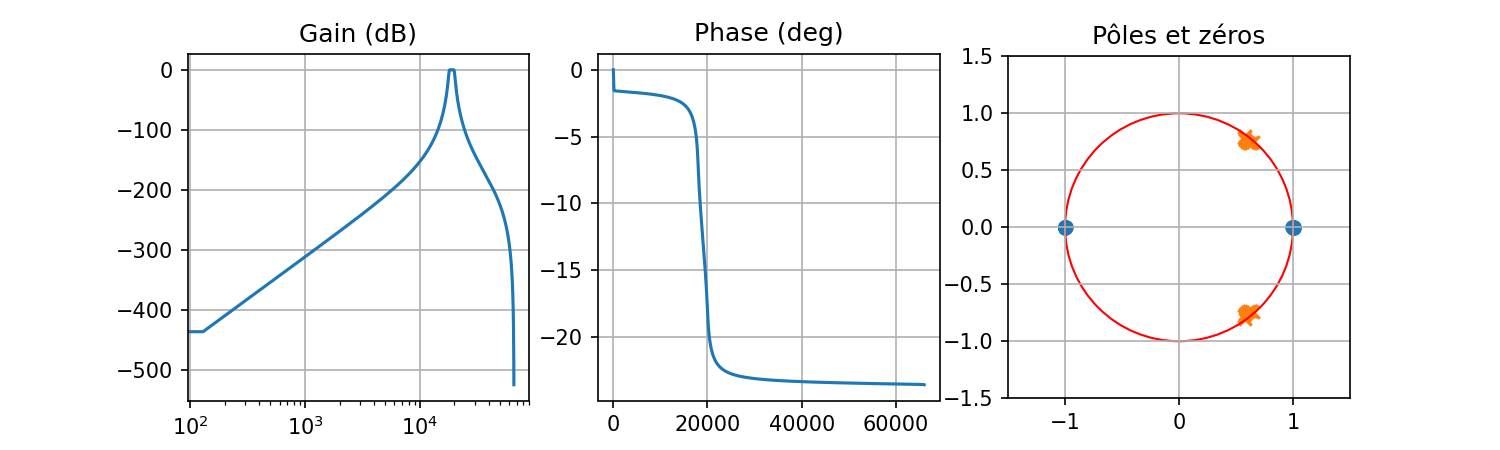

No handles with labels found to put in legend.


In [23]:
# Filtre2
FILTRE2 = filtre()
fig, ax = plt.subplots(1,3,figsize=(10,3))
FILTRE2.display(ax, fig)

#### 2.2.3) Filtrer le signal stéréphonique avec le filtre FILTRE2 obtenu. Vérifier son bon fonctionnement en traçant l'allure temporelle et le contenu fréquentiel de son signal de sortie. Conclure.

<IPython.core.display.Javascript object>


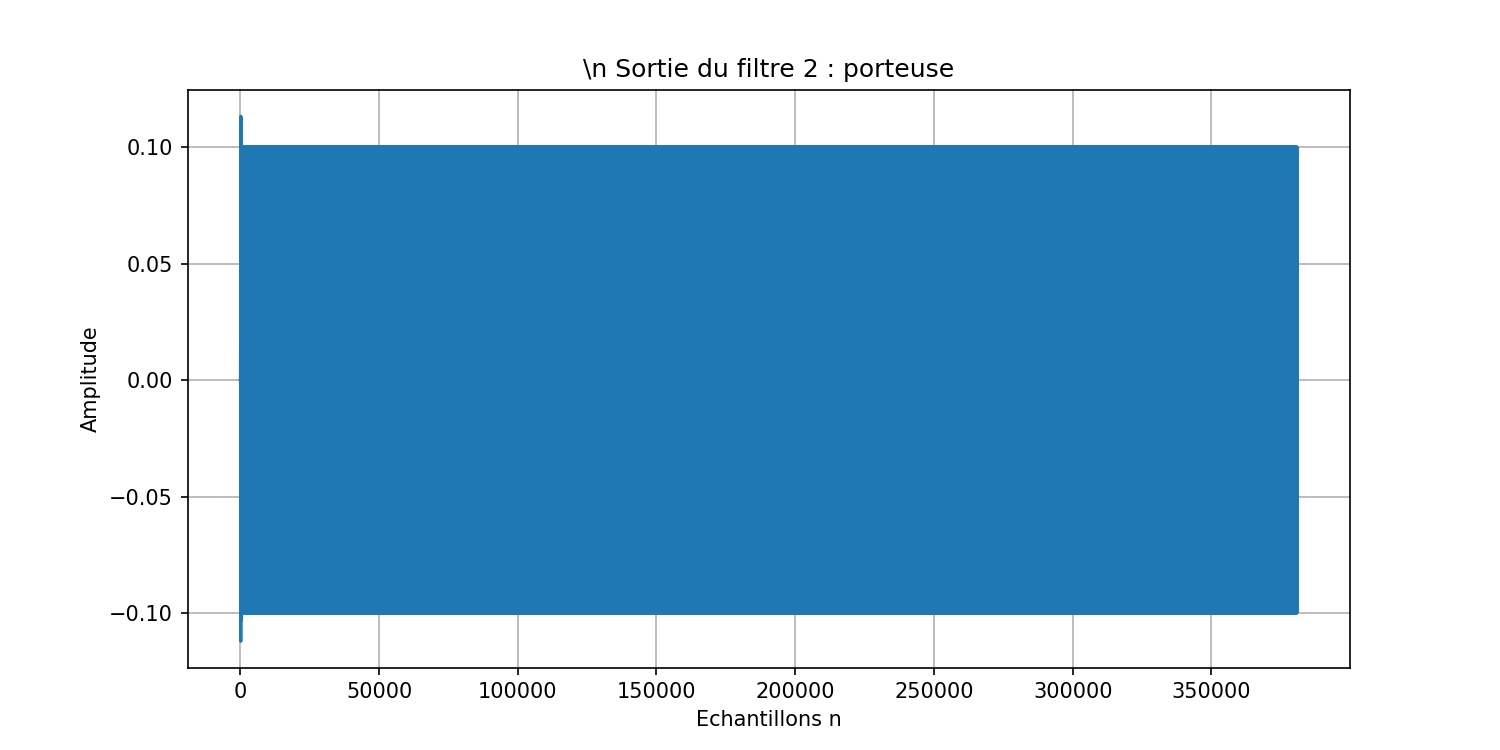

<IPython.core.display.Javascript object>


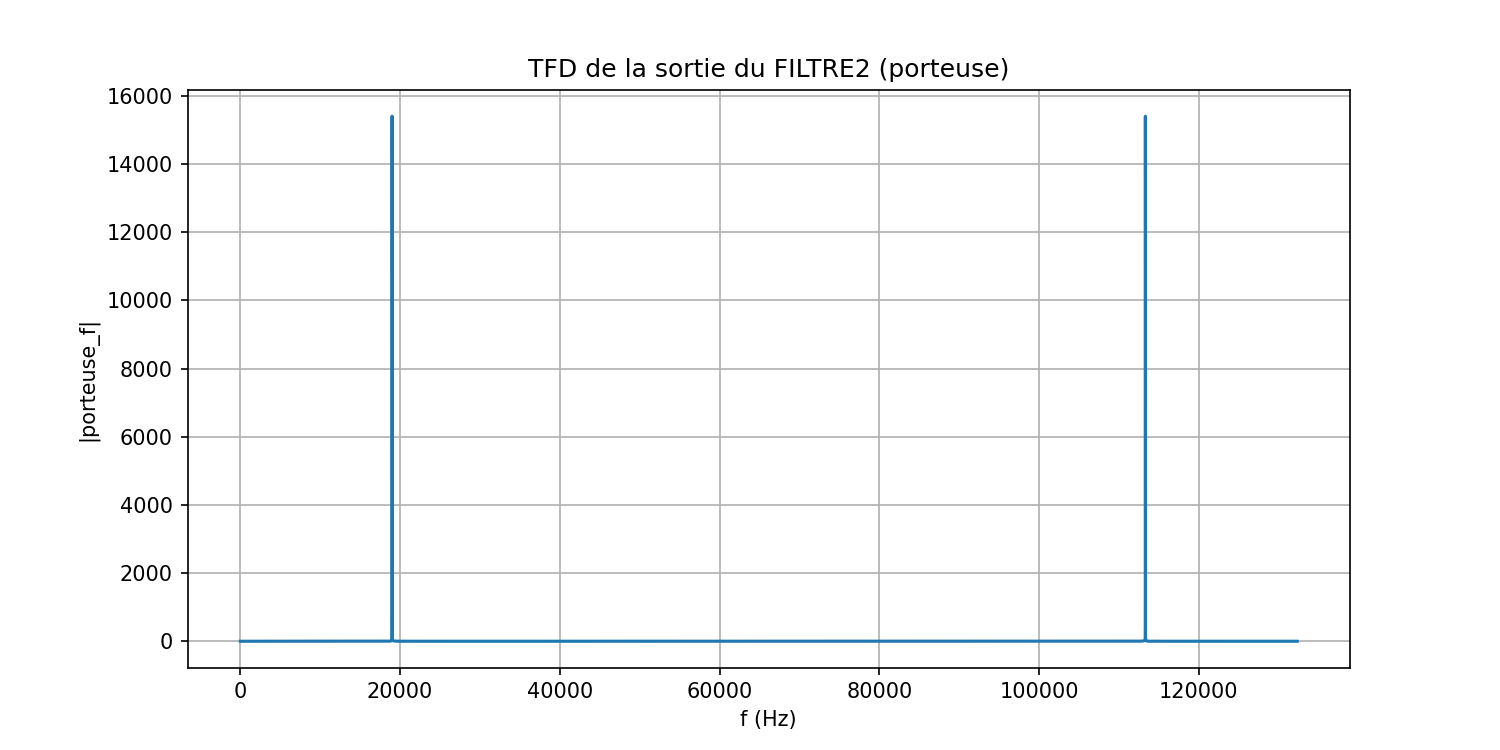

In [28]:
# Code à compléter
# Filtrage
n, porteuse = FILTRE2.filter(stereo)

# Tracé de l'allure temporelle
plt.figure(figsize=(10,5))
plt.step(n, porteuse)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'\\n Sortie du filtre 2 : porteuse')
plt.grid()

# Contenu fréquentiel
f = np.arange(0,Fe,Fe/len(porteuse))
porteuse_f = np.fft.fft(porteuse)
plt.figure(figsize=(10,5))
plt.plot(f,abs(porteuse_f))
plt.title('TFD de la sortie du FILTRE2 (porteuse)'); plt.xlabel('f (Hz)'); plt.ylabel('|porteuse_f|'); plt.grid()

## 2.3/ Mise en œuvre du démultiplexeur

Nous disposons maintenant des 2 filtres **FILTRE1** et **FILTRE2** nécessaire à la mise en œuvre du multiplexeur complet reproduit à nouveau sur la figure suivante.
<img src="img/archi.png" width=600>
<p style="text-align: center">Fig.3 : Schéma de principe du démultiplexeur stéréo.</p>

Il s'agit maintenenant de récupérer les 2 signaux **G+D** et **G-D** grâce à cette architecture. Pour cela, vous disposez de la fonction ```demultiplex(stereo, FILTRE1, FILTRE2)``` qui implémente pour vous l'architecture complète de la figure 3 et prend en paramètre les 2 filtres que vous avez synthétisé.

#### 2.3.1) Utiliser la fonction ```demultiplex(stereo, FILTRE1, FILTRE2)``` (en adaptant les valeurs des paramètres si nécessaire) pour extraire les 2 signaux G+D (monophonique) et G-D du signal stéréophonique.

In [30]:
# Modifier FILTRE1 et/ou FILTRE 2 par les variables utilisées plus haut
n, g_plus_d, g_moins_d = demultiplex(stereo, FILTRE1_RII, FILTRE2)

#### 2.3.2) Combiner les deux signaux G+D et G-D de façon à obtenir les signaux gauche G et droite D seuls. Tracer leurs allure temporelles.

<IPython.core.display.Javascript object>


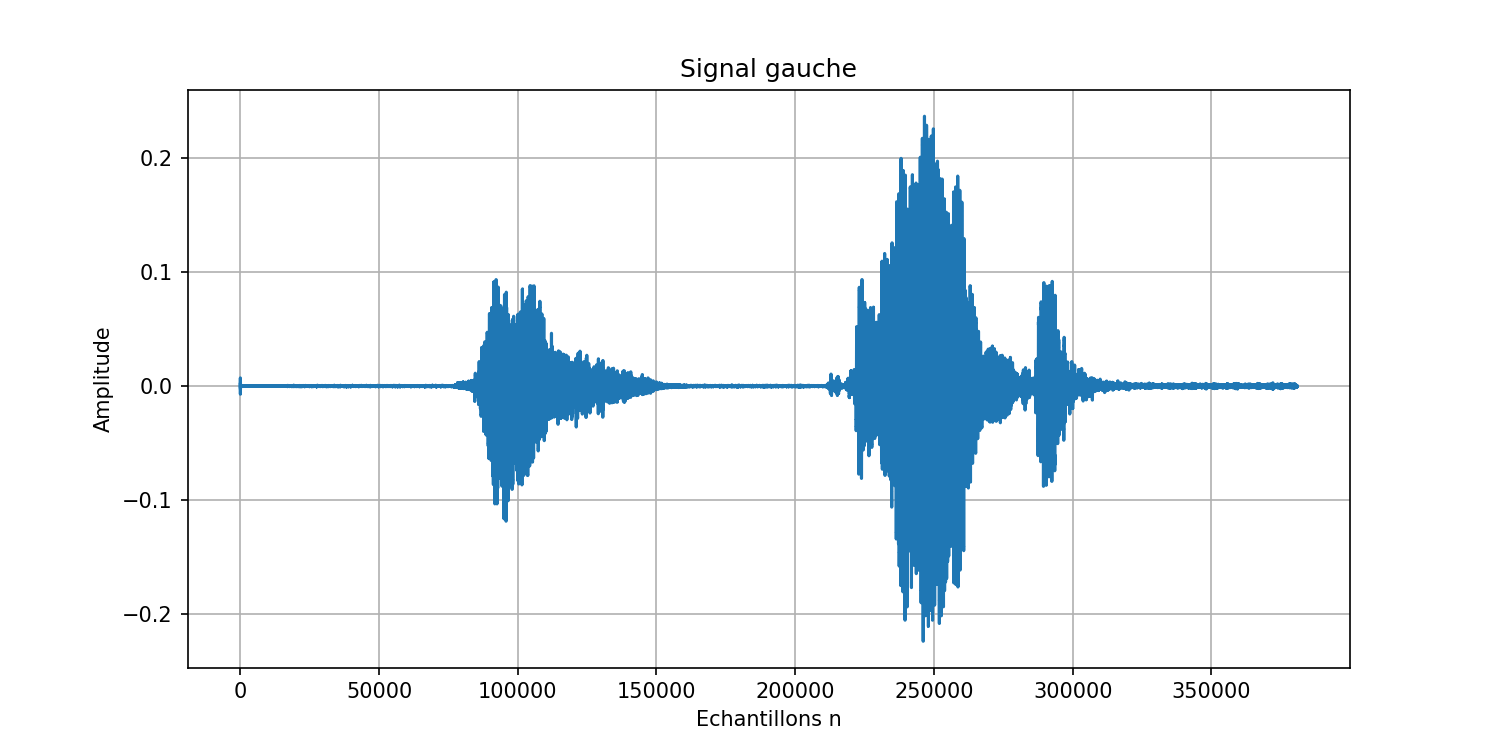

<IPython.core.display.Javascript object>


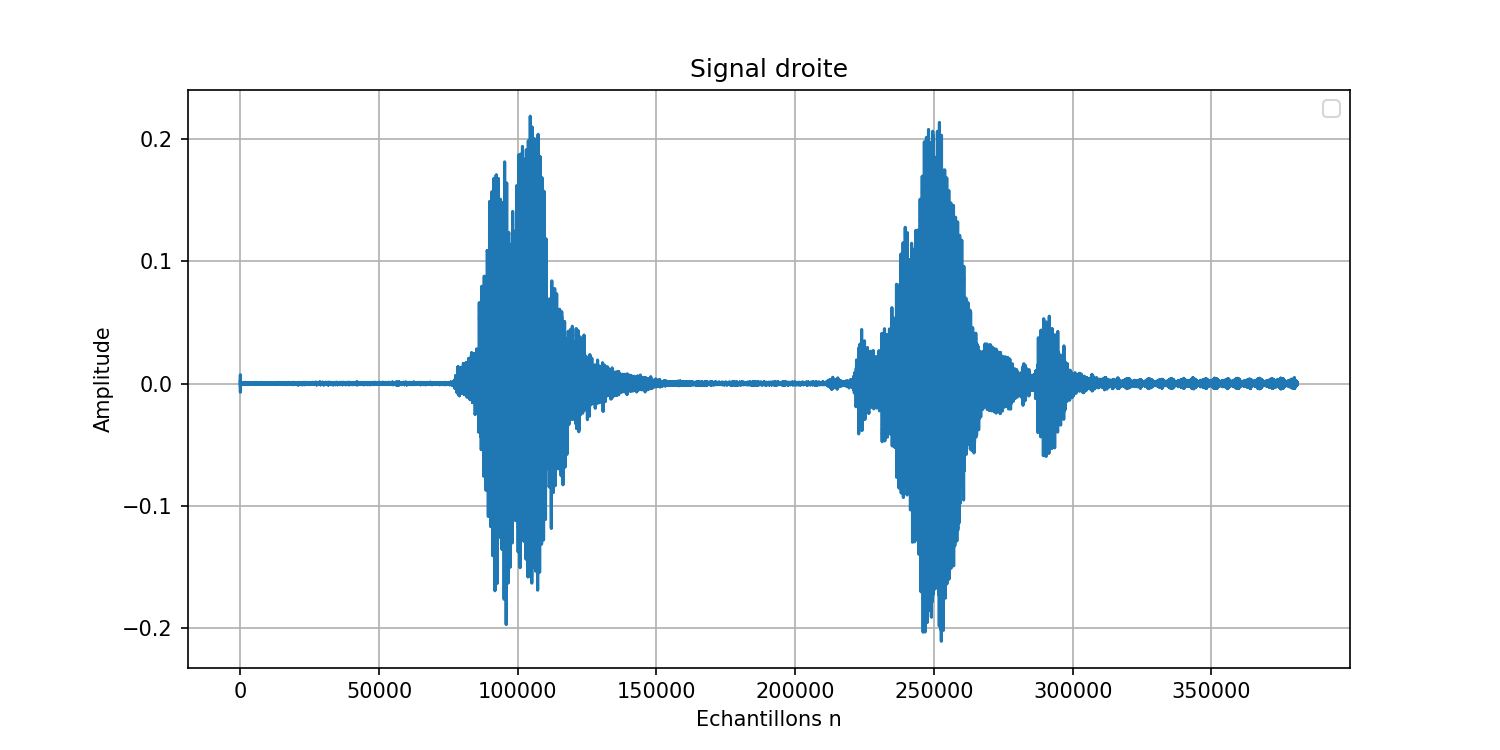

In [31]:
# Code à compléter

# Signal gauche
g = (g_plus_d + g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, g)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal gauche')
plt.grid()

# Signal droite
d = (g_plus_d - g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, d)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal droite')
plt.grid()

#### 2.3.3) Ecouter les signaux obtenus. A-t'on réussi à séparer les signaux gauche G et droite D ? Expliquer.

In [32]:
# Code à compléter
display(Audio(g, rate=Fe))
display(Audio(d, rate=Fe))

#### 2.3.4) Modifier en conséquence les filtres FILTRE1 et FILTRE2 pour que le démultiplexage fonctionne correctement. Tracer l'allure des signaux obtenus, et vérifier en écoutant les signaux que les modifications apportées fonctionnent. Conclure

<IPython.core.display.Javascript object>


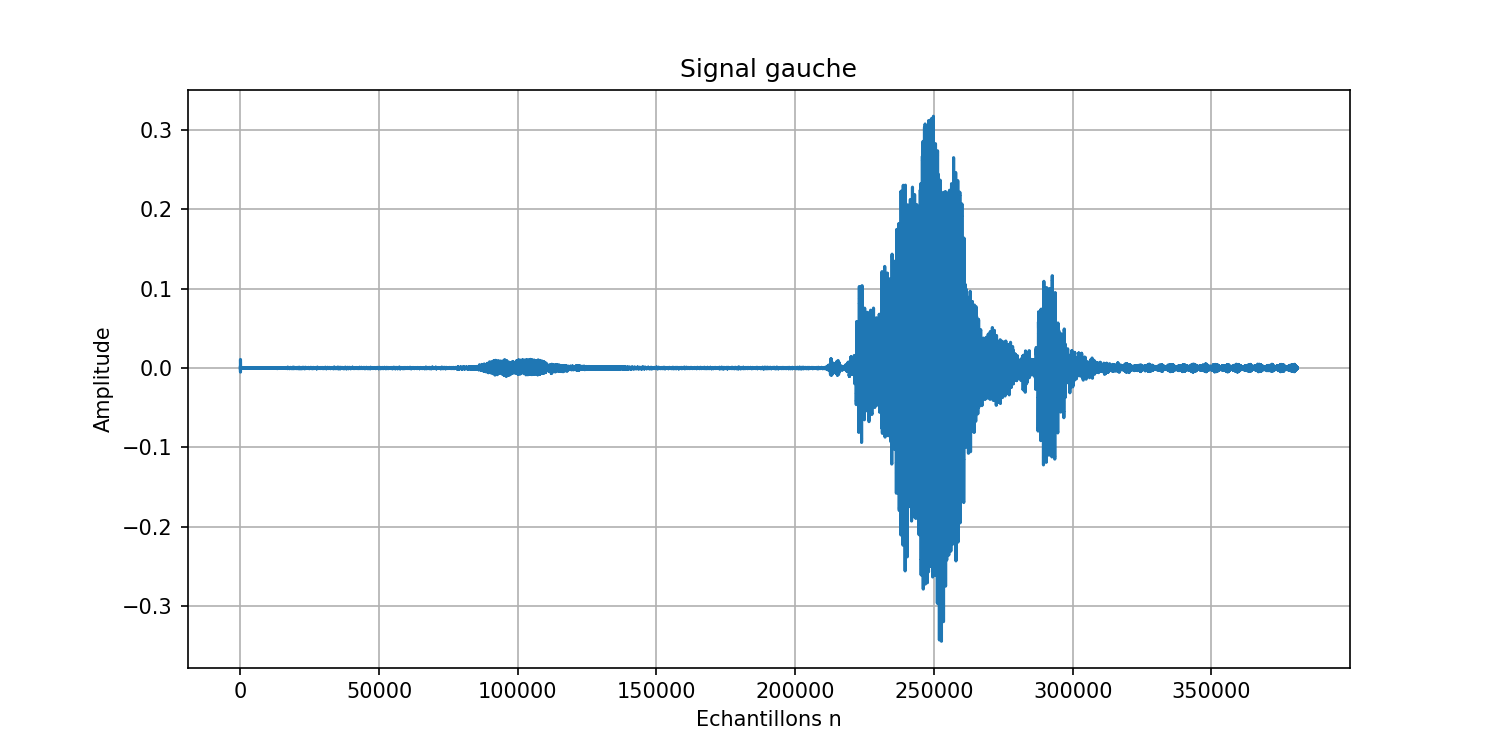

<IPython.core.display.Javascript object>


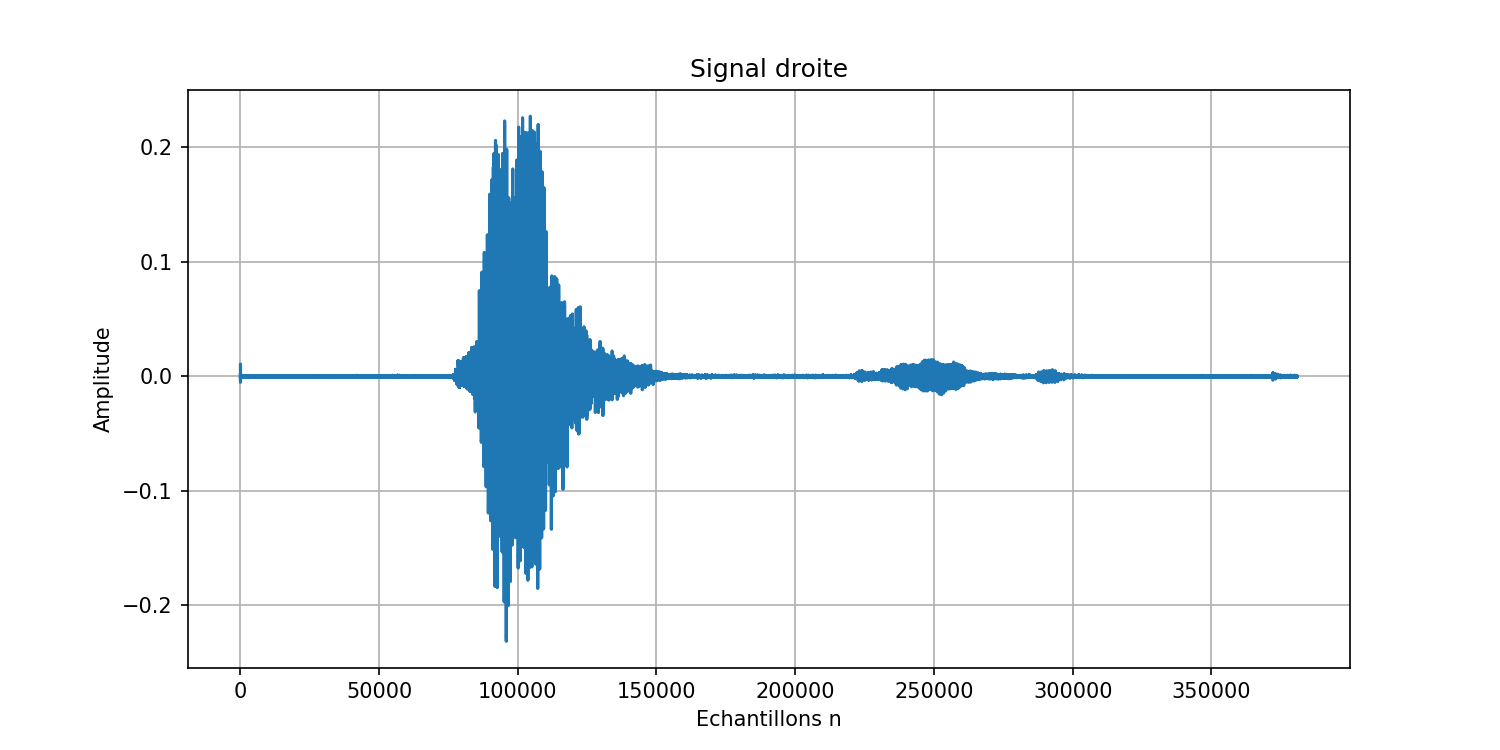

In [33]:
# Code à compléter
n, g_plus_d, g_moins_d = demultiplex(stereo, FILTRE1_RIF, FILTRE2)
# Signal gauche
g = (g_plus_d + g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, g)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal gauche')
plt.grid()

# Signal droite
d = (g_plus_d - g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, d)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal droite')
plt.grid()

display(Audio(g, rate=Fe))
display(Audio(d, rate=Fe))

# Si on envoie le signal g à gauche, et d à droite :
display(Audio([g,d], rate=Fe))